In [61]:
# 다중선형회귀 - 자동차 연비 예측 - Network 구성 함수작성, 조기종료
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Concatenate
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf

    mpg  cylinders  displacement  horsepower  weight  acceleration  \
0  18.0          8         307.0       130.0    3504          12.0   
1  15.0          8         350.0       165.0    3693          11.5   

   model year  origin                   car name  
0          70       1  chevrolet chevelle malibu  
1          70       1          buick skylark 320  
    mpg  cylinders  displacement  horsepower  weight  acceleration  \
0  18.0          8         307.0       130.0    3504          12.0   
1  15.0          8         350.0       165.0    3693          11.5   

   model year  origin  
0          70       1  
1          70       1  
                   mpg  displacement  horsepower    weight
mpg           1.000000     -0.804203   -0.778427 -0.831741
displacement -0.804203      1.000000    0.897257  0.932824
horsepower   -0.778427      0.897257    1.000000  0.864538
weight       -0.831741      0.932824    0.864538  1.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entr

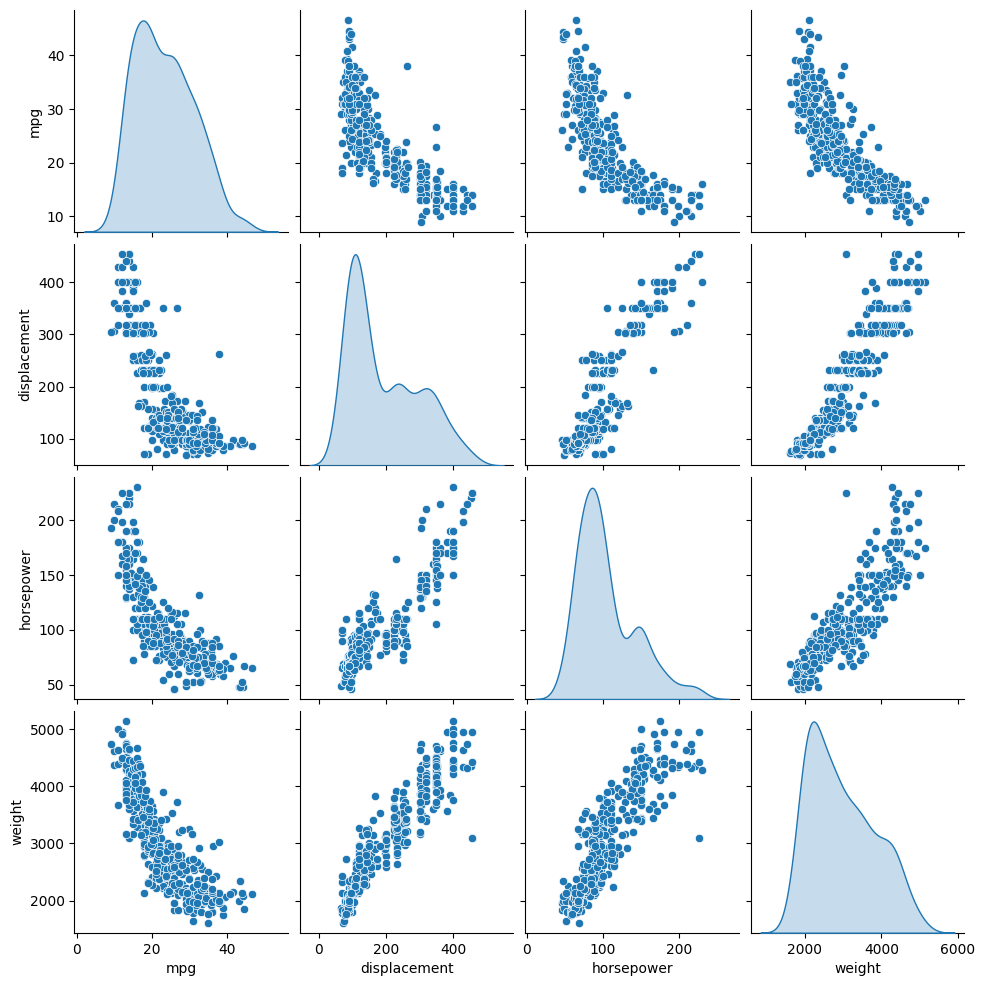

In [62]:
dataset = pd.read_csv('https://raw.githubusercontent.com/pykwon/python/refs/heads/master/testdata_utf8/auto-mpg.csv', na_values='?')
print(dataset.head(2))
del dataset['car name']
print(dataset.head(2))

dataset.drop(['cylinders','acceleration','model year','origin'], axis='columns', inplace=True)

print(dataset.corr()) # 상관계수
dataset.info()
print(dataset.isna().sum())

dataset = dataset.dropna()
print(dataset.isna().sum())

sns.pairplot(dataset[['mpg', 'displacement','horsepower','weight']], diag_kind='kde')
plt.show()

In [63]:
# train / test split
train_dataset = dataset.sample(frac=0.7, random_state=123)
test_dataset = dataset.drop(train_dataset.index)
# print(train_dataset[:2], train_dataset.shape)
# print(test_dataset[:2], test_dataset.shape)

# 표준화 - 수식 (관찰값 - 평균)/표준편차
train_stat = train_dataset.describe()
# print(train_stat)
train_stat.pop('mpg')
# print(train_stat.T)
train_stat = train_stat.T

def std_func(x):
    return (x - train_stat['mean'])/train_stat['std']

# print(std_func(train_dataset[:3]))

st_train_data = std_func(train_dataset)
st_train_data = st_train_data.drop(['mpg'], axis='columns')
print(st_train_data[:2])

st_test_data = std_func(test_dataset)
st_test_data = st_test_data.drop(['mpg'], axis='columns')
print(st_test_data[:2])

# label
train_label = train_dataset.pop('mpg')
print(train_label[:2])
test_label = test_dataset.pop('mpg')
print(test_label[:2])

     displacement  horsepower    weight
222      0.599039    0.133053  1.247890
247     -1.042328   -0.881744 -1.055604
   displacement  horsepower    weight
1      1.443171    1.528399  0.823075
2      1.143035    1.147850  0.525588
222    17.0
247    39.4
Name: mpg, dtype: float64
1    15.0
2    18.0
Name: mpg, dtype: float64


In [68]:
def build_model():
    network = Sequential([
        Input(shape=(3,)),
        Dense(32, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='linear'),
    ])
    
    opti = tf.keras.optimizers.Adam(learning_rate=0.01)
    network.compile(optimizer=opti, loss='mean_squared_error', metrics=['mse','mae'])
    
    return network
    
model = build_model()
print(model.summary())


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_27 (Dense)                │ (None, 32)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,217 (4.75 KB)

 Trainable params: 1,217 (4.75 KB)

 Non-trainable params: 0 (0.00 B)

None


In [69]:
# 학습
epochs = 5000

# 조기 종료
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', baseline=0.03, patience=50)

history = model.fit(st_train_data, train_label, batch_size=32, epochs=epochs, validation_split=0.2, verbose=2, callbacks=[early_stop]) # monitor='val_loss'을 사용했기 때문에 fit에 validation을 써야한다

df = pd.DataFrame(history.history)
print(df.head(3))

Epoch 1/5000
7/7 - 1s - 135ms/step - loss: 587.6707 - mae: 23.2488 - mse: 587.6707 - val_loss: 562.4363 - val_mae: 22.8556 - val_mse: 562.4363
Epoch 2/5000
7/7 - 0s - 14ms/step - loss: 537.0259 - mae: 22.6120 - mse: 537.0259 - val_loss: 487.4008 - val_mae: 21.5742 - val_mse: 487.4008
Epoch 3/5000
7/7 - 0s - 13ms/step - loss: 489.4614 - mae: 21.4281 - mse: 489.4614 - val_loss: 441.7227 - val_mae: 20.1728 - val_mse: 441.7227
Epoch 4/5000
7/7 - 0s - 13ms/step - loss: 477.8333 - mae: 20.3970 - mse: 477.8333 - val_loss: 396.6981 - val_mae: 18.8982 - val_mse: 396.6981
Epoch 5/5000
7/7 - 0s - 13ms/step - loss: 398.5229 - mae: 19.0549 - mse: 398.5229 - val_loss: 343.6728 - val_mae: 17.8174 - val_mse: 343.6728
Epoch 6/5000
7/7 - 0s - 14ms/step - loss: 322.9388 - mae: 17.0790 - mse: 322.9388 - val_loss: 282.7285 - val_mae: 15.8427 - val_mse: 282.7285
Epoch 7/5000
7/7 - 0s - 15ms/step - loss: 248.4701 - mae: 15.0557 - mse: 248.4701 - val_loss: 193.6601 - val_mae: 13.0786 - val_mse: 193.6601
Epoch

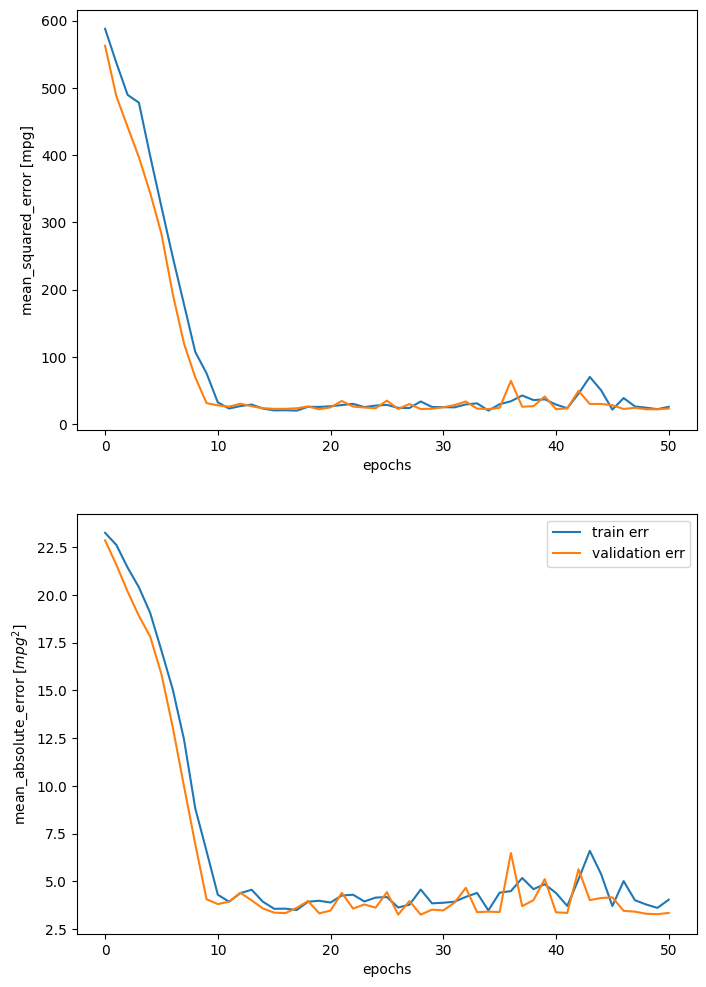

In [ ]:
# 모델 학습 정보 시각화
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    # print(hist.head(3))
    plt.figure(figsize=(8,12))
    plt.subplot(2,1,1)
    plt.xlabel('epochs')
    plt.ylabel('mean_squared_error [mpg]')
    plt.plot(hist['epoch'], hist['mse'], label='train err')
    plt.plot(hist['epoch'], hist['val_mse'], label='validation err')
    
    plt.subplot(2,1,2)
    plt.xlabel('epochs')
    plt.ylabel('mean_absolute_error [$mpg^2$]')
    plt.plot(hist['epoch'], hist['mae'], label='train err')
    plt.plot(hist['epoch'], hist['val_mae'], label='validation err')
    
    plt.legend()
    plt.show()

plot_history(history)

In [ ]:
loss, mse, mae = model.evaluate(st_test_data, test_label)
print('test dataset으로 평가 loss : {:5.3f}'.format(loss))
print('test dataset으로 평가 mse : {:5.3f}'.format(mse))
print('test dataset으로 평가 mae : {:5.3f}'.format(mae))

# 새로운 값으로 예측
new_data = pd.DataFrame({'displacement' : [300,400], 'horsepower':[120,140], 'weight':[2000, 4000]})
st_new_data = std_func(new_data)
new_pred = model.predict(st_new_data).ravel()
print('예측 결과 : ', new_pred)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 16.5634 - mae: 3.2826 - mse: 16.5634
test dataset으로 평가 loss : 16.563
test dataset으로 평가 mse : 16.563
test dataset으로 평가 mae : 3.283
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
예측 결과 :  [20.65799  13.603427]
